<a href="https://colab.research.google.com/github/urness/CS167Fall2025/blob/main/Day09_Metrics_Testing_and_Decision_TreesSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS167: Day09
##Metrics, Testing, and Decision Trees

#### CS167: Machine Learning, Fall 2025


## Before we get started, let's load (and clean) the dataset:
Make sure you change the path to match your Google Drive.


In [21]:
import pandas as pd
import numpy as np

# The first step is to mount your Google Drive to your Colab account.
#You will be asked to authorize Colab to access your Google Drive. Follow the steps they lead you.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
#import the data:
#make sure the path on the line below corresponds to the path where you put your dataset.
vehicles_df = pd.read_csv('/content/drive/MyDrive/CS167/datasets/vehicles.csv')

/tmp/ipython-input-777305997.py:3: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicles_df = pd.read_csv('/content/drive/MyDrive/CS167/datasets/vehicles.csv')


In [23]:
# get only vehicles with "Regular" fuel type and columns ['comb08', 'year', 'cylinders', 'displ']
regular_vehicles = vehicles_df[vehicles_df.fuelType =="Regular"]
regular_vehicles_subset = regular_vehicles[['comb08', 'year', 'cylinders', 'displ']]

#clean the data; dropping all rows that contain null values
regular_vehicles_cleaned = regular_vehicles_subset.dropna()
regular_vehicles_cleaned.head()

#let's work with only 1,000 rows
regular_vehicles_cleaned = regular_vehicles_cleaned.head(1000)

In [24]:
#normalize the data

#year
yr_mean = regular_vehicles_cleaned['year'].mean()
yr_std = regular_vehicles_cleaned['year'].std()

#cylinders
cy_mean = regular_vehicles_cleaned['cylinders'].mean()
cy_std = regular_vehicles_cleaned['cylinders'].std()

#displ
dp_mean = regular_vehicles_cleaned['displ'].mean()
dp_std = regular_vehicles_cleaned['displ'].std()

#make a copy of the dataframe
normalized_vehicle_df = regular_vehicles_cleaned.copy()

#replace column with each entry's z-score
normalized_vehicle_df['year'] = (normalized_vehicle_df['year'] - yr_mean)/yr_std
normalized_vehicle_df['cylinders'] = (normalized_vehicle_df['cylinders'] - cy_mean)/cy_std
normalized_vehicle_df['displ'] = (normalized_vehicle_df['displ'] - dp_mean)/dp_std



---



##1. What does the `mystery_function` do?





In [25]:
def mystery_function(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    Calculate ???? between two pandas Series,
    """
    total_error = 0.0
    n = len(y_true)

    for i in range(n):
        total_error += abs(y_true.iloc[i] - y_pred.iloc[i])

    return total_error / n

In [27]:
def mean_absolute_error(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    Calculate mean absolute error between two pandas Series,
    """
    total_error = 0.0
    n = len(y_true)

    for i in range(n):
        total_error += abs(y_true.iloc[i] - y_pred.iloc[i])

    return total_error / n

In [28]:
# Example data
actual = pd.Series([3, -0.5, 2, 7])
predicted = pd.Series([2.5, 0.0, 2, 8])

result = mystery_function(actual, predicted)
print("RESULT:", result)

RESULT: 0.5


Rename the `mystery_function` to be something that is more descriptive.

##2. Write a function `mean_squared_error `


In [12]:
#def mean_squared_error(y_true: pd.Series, y_pred: pd.Series) -> float:

In [29]:
import pandas as pd

def mean_squared_error(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    Calculate mse between two pandas Series,
    """
    total_error = 0.0
    n = len(y_true)

    for i in range(n):
        total_error += (y_true.iloc[i] - y_pred.iloc[i])**2

    return total_error / n

##3. How can you test your code to make sure it's working correctly?

**Run some test cases to show your work. Prove to yourself that your functions work as expected.**


In [30]:
actual = pd.Series([3, 2, 1, 0])
predicted = pd.Series([2,1,0,1])
# mean squared error should be 1
mse = mean_squared_error(actual, predicted)
print("Mean Squared Error:", mse)



Mean Squared Error: 1.0


In [31]:
actual = pd.Series([3, 2, 1, 0])
predicted = pd.Series([1,0,-1,2])
# mean absolute error should be 2
mae = mean_absolute_error(actual, predicted)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 2.0


##4. Implement cross validation -– create training and testing data.
Use approximately the first 20% of the shuffled set as testing data.


In [32]:
# Shuffle the data

shuffled_data = normalized_vehicle_df.sample(frac=1, random_state=42)

# Compute the split index (20% for test)
test_size = int(0.2 * len(shuffled_data))

# Set up training and testing sets
test_data = shuffled_data.iloc[:test_size]     # first 20%
train_data = shuffled_data.iloc[test_size:]    # remaining 80%


##(This is a big step)
##6. Refer to the code from last week that will graph the various values of k for the kNN algorithm.

**Note that you will have to adjust the knn algorithm to use a regression**

**Determine the best value of k.**

**Supply a graph to justify your conclusion.**


Let's bring in our `kNN()` function--here I'm calling it `classify_kNN()` becuase it uses `mode()` to return the prediction which only works for classifcation.

In [33]:
def regression_kNN(new_example,train_data,k):
    #making a copy of the training set just so we don't mess up the original
    train_data_copy = train_data.copy()

    # 1. calculate distances
    train_data_copy['distance_to_new'] = np.sqrt(
     (new_example['year'] - train_data_copy['year'])**2
    +(new_example['displ'] - train_data_copy['displ'])**2
    +(new_example['cylinders'] - train_data_copy['cylinders'])**2)

    # 2. sort
    sorted_data = train_data_copy.sort_values(['distance_to_new'])

    # 3. predict
    prediction = sorted_data.iloc[0:k]['comb08'].mean()

    return prediction

Now, let's write a function `regression_all_kNN(test_data, train_data,k):` that:
- goes through each example in the `test_data`, and gets the prediction using our `regression_kNN()` function
- It will return a pandas `Series` that has the predictions for each row in `test_data`.

It should look something like this:

In [34]:
def regression_all_kNN(test_data, train_data, k) -> pd.Series:
    """
    Apply kNN regression to each row in the test data.

    Parameters:
        test_data (pd.DataFrame): Data to classify.
        train_data (pd.DataFrame): Training set with labels.
        k (int): Number of neighbors.

    Returns:
        pd.Series: Predicted values for each row in test_data.
    """
    results = []

    for i in range(len(test_data)):
        value = regression_kNN(test_data.iloc[i], train_data, k)
        results.append(value)

    return pd.Series(results)

Now, let's pull it all together and see how our kNN does:

In [35]:
from sklearn.metrics import accuracy_score

#let's try it with 5-nn

predictions5NN = regression_all_kNN(test_data,train_data,5)

#this will print out our predictions so we can see:
# print('ACTUAL            PREDICTIONS')
# for i in range(len(test_data)):
#     print(test_data['comb08'].iloc[i], " ", predictions5NN.iloc[i] )

# give us an idea of the scale of the errors
mse = mean_squared_error(test_data['comb08'], predictions5NN)
print("mse:", mse)
mae = mean_absolute_error(test_data['comb08'], predictions5NN)
print("mae:", mae)


mse: 4.8096000000000005
mae: 1.5459999999999994


Now, let's explore what the accuracy is for a variety of different values of k

mse: 1 7.335
mse: 3 5.097222222222225
mse: 5 4.8096000000000005
mse: 9 4.479074074074076
mse: 11 4.557107438016534
mse: 13 4.875798816568038
mse: 15 5.195111111111112
mse: 17 5.083096885813149
mse: 19 5.142049861495842
mse: 21 5.299727891156462


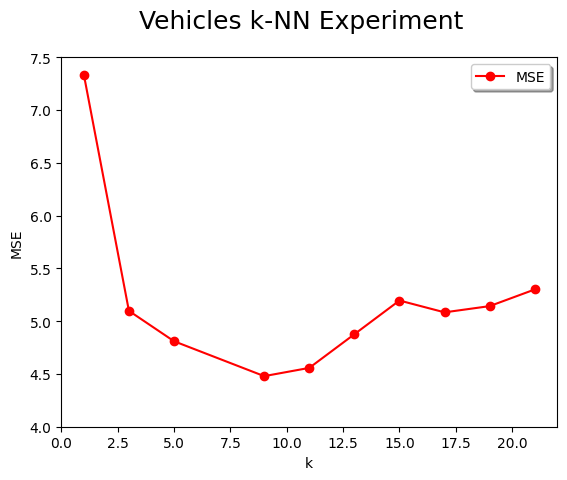

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

k_vals = [1,3,5,9,11,13,15,17,19,21]
kNN_mse = []

for k in k_vals:
    predictions = regression_all_kNN(test_data,train_data,k)
    mse = mean_squared_error(test_data['comb08'],predictions)
    print("mse:", k,mse)
    kNN_mse.append(mse)

plt.suptitle('Vehicles k-NN Experiment',fontsize=18)
plt.xlabel('k')
plt.ylabel('MSE')
plt.plot(k_vals,kNN_mse,'ro-',label='MSE')
plt.legend(loc='upper right', shadow=True)
plt.axis([0,22,4,7.5])

plt.show()